## Load data and library

In [1]:
#!python -m pip uninstall JPype1

In [2]:
#!pip install konlpy --user

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
import tqdm

from konlpy.tag import Okt

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [4]:
train=pd.read_csv('../data/train.csv')
test=pd.read_csv('../data/test.csv')
sample_submission=pd.read_csv('../data/sample_submission.csv')

In [5]:
train.head(3)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0
2,2,2016,중소기업기술혁신개발,중소기업청,신규,혁신기업기술개발,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n* 소비자 및 바...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n- Tencel/...,* 국내 독자적인 비목질계 셀룰로오스 자원의 파이버 및 부직포 제조 등의 기술 확보...,"기능성 샐룰로오스 파이버,천연섬유,기능성 부직포,뷰티&amp;케어 제품,미용 솜","functional cellulose fiber,natural fiber,funct...",0


In [6]:
test.head(3)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드
0,174304,2016,경제협력권산업육성,산업통상자원부,신규,자동차융합부품,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...,○ 차체 점용접부의 품질 검사를 위한 64채널 무선 기반 C-Scan 탐촉자 개발\...,○ 1차년도\n\n . 개발 탐촉 시스템의 성능 평가 위한 표준 시편 제작 시...,○ 기술적 파급효과\n\n - 본 연구에서 개발된 R-FSSW 접합 기술은 기존 ...,"마찰교반점용접, 비파괴 검사, 초음파 탐상, 씨 스캔, 용접 품질 평가","Friction Stir Spot Welding, Non-destructive ev..."
1,174305,2018,개인기초연구(과기정통부)(R&D),과학기술정보통신부,계속,신진연구(총연구비5천이상~1.5억이하),다입자계를 묘사하는 편미분방정식에 대한 연구,자연계에는 입자의 개수가 아주 큰 다양한 다입자계가 존재한다. 이런 다입자계의 효...,연구과제1. 무한입자계의 동역학 / 작용소(operator) 방정식에 대한 연구\n...,본 연구는 물리학에서 중요한 대상인 다입자계를 묘사하는 모델방정식의 정당성을 보장하...,"다체계 방정식,동역학의 안정성,양자역학,고전역학,평균장 극한,고전극한,비상대론적 극한","many particle system,stability of dynamics,qua..."
2,174306,2017,개인기초연구(미래부),과학기술정보통신부,계속,자유공모,저출생체중아 가족을 위한 지역사회중심의 퇴원후 추후관리프로그램 개발,"저출생체중아는 정상 체중 출생아에 비하여 운동, 정신, 행동 및 정서발달장애가 빈번...",본 연구는 퇴원 후 저출생체중아의 퇴원 후 추후관리 프로그램 중 가정방문 모델과 가...,본 연구는 저출생체중아 가족 대상의 지역사회기반의 추후관리 사업에 대한 구체적인 모...,"저출생체중아,추후관리,조기개입,자조모임,가정방문","lowbirthweightinfant,followup,earlyinterventio..."


In [7]:
#labels_mapping = pd.read_csv('../data/labels_mapping_detailed.csv', index=False, encoding='utf-8-sig')
#labels_mapping.head()

In [8]:
sample_submission.head(5)

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0


In [9]:
print(train.shape)
print(test.shape)
print(sample_submission.shape)

(174304, 13)
(43576, 12)
(43576, 2)


## EDA

### Title of Projects

과제명 길이 최댓값: 229
과제명 길이 최솟값: 2
과제명 길이 평균값: 35.84252225995961
과제명 길이 중간값: 34.0


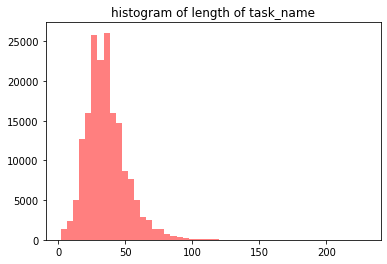

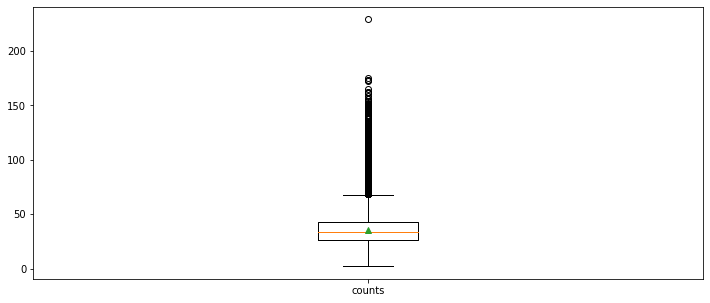

In [10]:
length=train['과제명'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of task_name')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('과제명 길이 최댓값: {}'.format(np.max(length)))
print('과제명 길이 최솟값: {}'.format(np.min(length)))
print('과제명 길이 평균값: {}'.format(np.mean(length)))
print('과제명 길이 중간값: {}'.format(np.median(length)))

### Abstracts - Research Details

요약문_연구내용 길이 최댓값: 3999
요약문_연구내용 길이 최솟값: 1
요약문_연구내용 길이 평균값: 699.2930282724435
요약문_연구내용 길이 중간값: 597.0


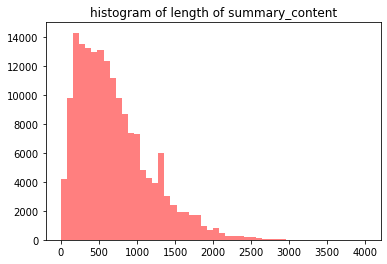

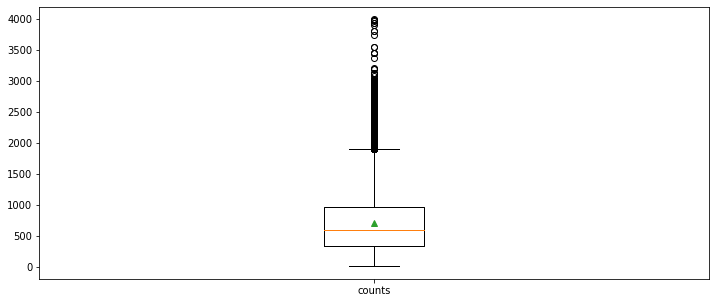

In [11]:
length=train['요약문_연구내용'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of summary_content')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_연구내용 길이 최댓값: {}'.format(np.max(length)))
print('요약문_연구내용 길이 최솟값: {}'.format(np.min(length)))
print('요약문_연구내용 길이 평균값: {}'.format(np.mean(length)))
print('요약문_연구내용 길이 중간값: {}'.format(np.median(length)))

### Abstract - Expected Outcome

요약문_기대효과 길이 최댓값: 3649
요약문_기대효과 길이 최솟값: 1
요약문_기대효과 길이 평균값: 400.4864374885258
요약문_기대효과 길이 중간값: 329.0


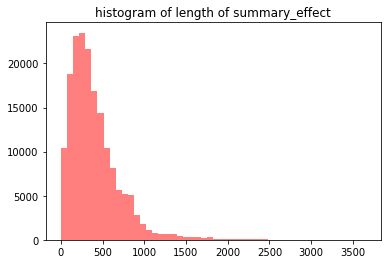

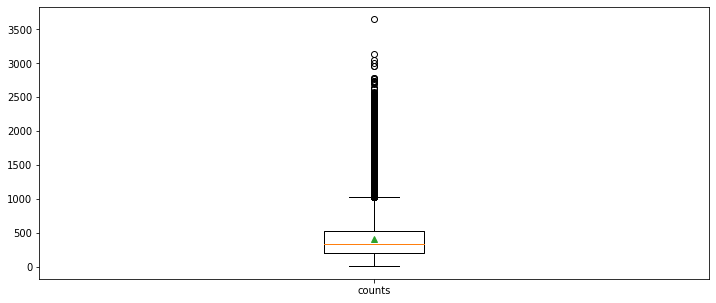

In [12]:
length=train['요약문_기대효과'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('histogram of length of summary_effect')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_기대효과 길이 최댓값: {}'.format(np.max(length)))
print('요약문_기대효과 길이 최솟값: {}'.format(np.min(length)))
print('요약문_기대효과 길이 평균값: {}'.format(np.mean(length)))
print('요약문_기대효과 길이 중간값: {}'.format(np.median(length)))

## Data Preprocessing

In [13]:
#해당 baseline 에서는 과제명 columns만 활용했습니다.
#다채로운 변수 활용법으로 성능을 높여주세요!
train=train[['과제명','label']]
test=test[['과제명']]

In [14]:
train.head(10)

,과제명,label
0,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,24
1,대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,0
2,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,0
3,소화기 암 진단용 분자영상 형광프로브 개발,0
4,위암환자의 항암제반응예측을 위한 BRCA 발현검사,0
5,국제 핵융합 재료조사시설(IFMIF)의 안정적 운전을 위한 고강도 빔 물리 연구,2
6,마이크로시스를 적용한 옥내·외 겸용 광케이블 개발,0
7,임상·오믹스 정보 통합 개방형 플랫폼 구축 및 다기관 검증,0
8,IoT기반 수출배 선과장 물류체계화 기술개발,0
9,지역 창조경제 생태계 활성화를 위한 바이오산업 인재 양성,0


In [15]:
test.head(10)

,과제명
0,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...
1,다입자계를 묘사하는 편미분방정식에 대한 연구
2,저출생체중아 가족을 위한 지역사회중심의 퇴원후 추후관리프로그램 개발
3,폴리싱용 5축 CNC 정밀 마이크로 시스템 개발
4,다결정재료의 미세조직구조를 고려한 확률론적 응력부식균열 생성예측모델 개발
5,DC 그리드용 차세대 DC 전력차단기에 관한 연구
6,현존선을 LNG연료추진선으로 Retrofit하기 위한 기술개발
7,전이 암세포의 점탄성 관련 keratin 재구축 조절 타겟들의 암 미세환경에서의 역...
8,국민안전 분석기술 개발
9,선택적 방사선 감응 기반 차세대 고성능 양이온 이차전지용 세퍼레이터 개발


In [16]:
#1. re.sub 한글 및 공백을 제외한 문자 제거
#2. okt 객체를 활용해 형태소 단위로 나눔 - 더욱 정확한 형태소 파싱이 필요할 수 있다
#3. remove_stopwords로 불용어 제거 - 불용어 처리를 위한 룰 추가 필요

def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    text=re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ]","", text)
    word_text=okt.morphs(text, stem=True)
    if remove_stopwords:
        word_review=[token for token in word_text if not token in stop_words]
    return word_review

In [17]:
stop_words=['은','는','이','가', '하','아','것','들','의','있','되','수','보','주','등','한']
okt=Okt()
clean_train_text=[]
clean_test_text=[]

In [18]:
for text in tqdm.tqdm(train['과제명']):
    try:
        clean_train_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    except:
        clean_train_text.append([])

100%|████████████████████████████████████████████████████████████████████████| 174304/174304 [1:29:45<00:00, 32.37it/s]


In [19]:
for text in tqdm.tqdm(test['과제명']):
    if type(text) == str:
        clean_test_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_text.append([])

100%|██████████████████████████████████████████████████████████████████████████| 43576/43576 [2:27:14<00:00,  4.93it/s]


In [20]:
len(clean_train_text), len(clean_test_text)

(174304, 43576)

In [21]:
import json

with open("clean_train_text.json", 'w') as f:
    json.dump(clean_train_text, f, indent=2)
with open("clean_test_text.json", "w") as f:
    json.dump(clean_test_text, f, indent=2)

### Load the processed text files

In [22]:
with open("clean_train_text.json", "r") as f:
    clean_train_text = json.load(f)
with open("clean_test_text.json", "r") as f:
    clean_test_text = json.load(r)

NameError: name 'r' is not defined

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = lambda x: x, lowercase=False)
train_features=vectorizer.fit_transform(clean_train_text)
test_features=vectorizer.transform(clean_test_text)

In [ ]:
train_features, test_features

## Modeling

In [ ]:
test_size = 0.2
random_seed = 42

train_x, eval_x, train_y, eval_y = train_test_split(train_features, train['label'], test_size = test_size, random_state = random_seed)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier (n_estimators = 100)
forest.fit(train_x, train_y)

In [ ]:
forest.score(eval_x, eval_y)

## Prediction and submission file

In [ ]:
forest.predict(test_features)

In [ ]:
sample_submission['label'] = forest.predict(test_features)

In [ ]:
sample_submission

In [ ]:
sample_submission.to_csv('rf_result.csv', index=False)